# Part 2: Feature Engineering and Modelling

## Introduction

Welcome to the second notebook where we use the scraped Jakarta Apartment Dataset. In this notebook, we will use the cleaned data from our previous notebook to create and evaluate regression models to predict the annual rent price rate of apartments in Jakarta and its surrounding. 

First, we'll analyze the numerical features of our dataset and check if the data has to be scaled and/or if the data has multicolinearity issues. Then, we'll create a baseline model. After that, the baseline model will be evaluated, and further feature engineerings will be done to improve our initial model. Finally, we'll evaluate our models and choose the best model.

## Importing Packages

In [1]:
# Essentials
import numpy as np
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import datetime
import random

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Models
import sklearn
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import lightgbm as lgb
from lightgbm import LGBMRegressor
warnings.filterwarnings(action='ignore', category = UserWarning)
from xgboost.sklearn import XGBRegressor

# Misc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

## Importing the Cleaned Data

In [5]:
df_clean = pd.read_csv('Cleaned Apartment Data.csv')

In [6]:
df_clean = df_clean.drop(['Unnamed: 0', 'URL', 'Unit_ID', 'FurnishedNew'], axis = 'columns')

In [7]:
df_clean

,No_Rooms,Bathroom,Locality,Region,Longitude,Latitude,Furnished,Area,AC,Water_Heater,...,Security,Basketball,Multipurpose_Room,Gym,Jogging,Tennis,Restaurant,Playground,Total_Facilities,AnnualPrice
0,1,1,Semanggi,Jakarta Selatan,106.819159,-6.226598,1,43.0,1,1,...,1,1,1,1,1,1,1,1,23,96000000
1,2,1,Kebon Jeruk,Jakarta Barat,106.756061,-6.192081,0,35.0,1,0,...,1,0,1,1,1,0,1,1,19,30000000
2,2,1,Kedoya,Jakarta Barat,106.757651,-6.186415,1,53.0,1,1,...,1,0,1,1,1,0,1,1,22,70000000
3,2,2,Pondok Indah,Jakarta Selatan,106.784600,-6.272637,1,85.0,1,1,...,1,1,1,1,1,1,1,1,24,576000000
4,2,1,Grogol,Jakarta Barat,106.796056,-6.153652,0,48.0,1,0,...,1,0,1,1,0,0,1,1,15,32000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142,2,1,Pekayon,Bekasi,106.993400,-6.243400,1,36.0,1,0,...,0,0,0,0,0,0,0,1,14,36000000
5143,0,1,BSD City,Tangerang,106.664000,-6.294400,1,32.0,1,1,...,1,0,1,1,0,0,0,1,16,60000000
5144,2,1,Setiabudi,Jakarta Selatan,106.829330,-6.216540,1,83.0,1,1,...,1,0,1,1,1,0,1,1,21,250000000
5145,2,1,Slipi,Jakarta Pusat,106.801738,-6.202296,1,68.0,1,1,...,1,1,1,1,1,1,1,1,24,108000000


Last but not least, let's improvise a bit and try to add a 'Is it in Jakarta or not' column. It will be a value of '1' for apartment units in Jakarta, and '0' for apartment units in the satelite region of Jakarta (Bogor, Depok, Tangerang, Bekasi).

In [8]:
Jakcheck = list()
for region in df_clean.Region:
    if 'Jakarta' in region:
        Jakcheck.append(1)
    else:
        Jakcheck.append(0)
        
df_clean['Jakcheck'] = Jakcheck

## Creating Baseline Model

We'll create a baseline model straight away to have a rough model on our dataset before improving anything. If our further feature engineering causes our model to be worse than the baseline model, then we know the feature engineering we perform is not ideal.

In this baseline model, we'll use one-time train test split (no cross validations) and create a simple Linear Regression.

In [9]:
X = df_clean[['No_Rooms', 'Bathroom', 'Longitude', 'Latitude', 'Furnished', 'Area', 'AC', 'Water_Heater', 
                    'Dining_Set', 'Bed', 'Kitchen', 'Fridge', 
                    'Washing_Machine', 'TV', 'ATM', 'TV_Cable', 'Grocery', 'Internet', 'Swim_Pool', 
                    'Laundry', 'Security', 'Basketball', 'Multipurpose_Room', 'Gym', 
                    'Jogging', 'Tennis','Restaurant', 'Playground', 'Total_Facilities', 'Jakcheck']]
y = df_clean[['AnnualPrice']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 23)

In [8]:
# function to evaluate accuracy
def evaluate(model, X_test, y_test, return_val = False):
    test_val = y_test['AnnualPrice'].to_numpy().reshape(len(y_test.AnnualPrice), 1)
    prediction = model.predict(X_test)
    plt.scatter(test_val, prediction)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.show()
    from sklearn import metrics
    print('MAE:', metrics.mean_absolute_error(test_val, prediction))
    print('MSE:', metrics.mean_squared_error(test_val, prediction))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(test_val, prediction)))
    print('R2 Score:', metrics.r2_score(test_val, prediction))
    print('Adjusted R2 Score:', 1-(1-metrics.r2_score(test_val, prediction))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))
    
    if return_val == True:
        return test_val, prediction

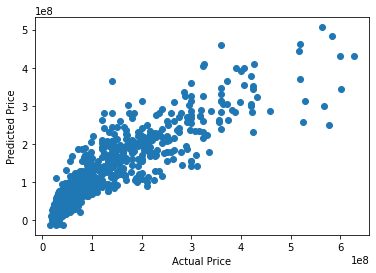

MAE: 27823217.045755442
MSE: 2001430900717810.5
RMSE: 44737354.645953424
R2 Score: 0.7948399711082925
Adjusted R2 Score: 0.7933336566524063


In [9]:
lm = LinearRegression()
lm.fit(X_train, y_train)
test_val, prediction = evaluate(lm, X_test, y_test, return_val = True)

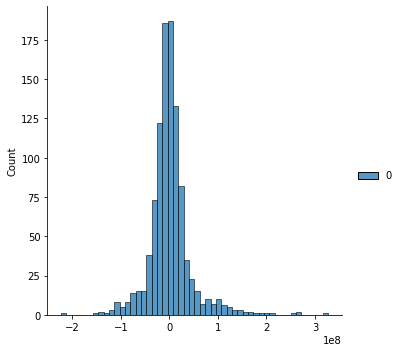

In [10]:
sns.displot(test_val - prediction, bins = 50)

Our baseline model surprisingly performs quite well. It managed to get a 78% R-squared score, with a relatively normal residual plot. What is R-squared and why should we care? R-squared measures the scatter of our data points around the fitted regression line. A high R-squared score represents that the observed data and fitted value have small differences. According to 'Statistics By Jim', who explained it ellegantly, R-squared is the percentage of the dependent variable variation that a linear model explains.

(Cite: https://statisticsbyjim.com/regression/interpret-r-squared-regression/)

In [11]:
# compute with statsmodels, another way, using formula

import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm

try:
    result = sm.ols(formula="AnnualPrice ~ No_Rooms + Bathroom + Longitude + Latitude + Furnished + Area + AC + Water_Heater + Dining_Set + Bed + Kitchen + Fridge + Washing_Machine + TV + ATM + TV_Cable + Grocery + Internet + Swim_Pool + Laundry + Security + Basketball + Multipurpose_Room + Gym + Jogging + Tennis + Restaurant + Playground + Total_Facilities + Jakcheck", data=df_clean).fit()
    print(result.summary())
except:
    result = sm.ols(formula="AnnualPrice ~ No_Rooms + Bathroom + Longitude + Latitude + Furnished + Area + AC + Water_Heater + Dining_Set + Bed + Kitchen + Fridge + Washing_Machine + TV + ATM + TV_Cable + Grocery + Internet + Swim_Pool + Laundry + Security + Basketball + Multipurpose_Room + Gym + Jogging + Tennis + Restaurant + Playground + Total_Facilities + Jakcheck", data=df_clean).fit()
    print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            AnnualPrice   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     559.9
Date:                Sun, 06 Dec 2020   Prob (F-statistic):               0.00
Time:                        11:40:33   Log-Likelihood:                -98025.
No. Observations:                5147   AIC:                         1.961e+05
Df Residuals:                    5116   BIC:                         1.963e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.579e+09   1.15e+0

We can get a more detailed result from our regression when we use the statsmodels library. It might seem like a wall of text, but don't worry - we'll look at what we can derive from this result.

- R-Squared and Adjusted R-Squared are fairly similar. Adjusted R-Squared is always lower than R-Squared because it penalizes the model if the model uses features which are not significant. So, for example, if we add another insignificant feature to the model, the Adjusted R-Squared will decrease, while R-Squared will mostly stay the same or increase. If the model's Adjusted R-Squared is way below the R-Squared, it means there are a lot of insignificant features. Fortunately for us, that doesn't seem to be the case.


- We have a 0 p-value of the F-statistic. In plain English, the F-statistic tests whether there is a significant linear relation between our features (independent variables) and our target (dependent variable). The null hypothesis is that there is no relation ebtween our features and our target, meaning the regression model arrives at such result by chance. When the p-value is 0 (or below alpha, which is usually 0.05), we can reject the null hypothesis, and assure ourselves that our model fits the data well because indeed - there are linear relations between our features and our target.


- In the central table, there is a list of our features. The column 'coefficient' tells us what each feature's coefficients are. Remember that these coefficients explain the relation of our feature to our target variable. Aside from thee 'coefficient' column, we also have 't' column. This 't' column is the t-statistic of each feature in yet another statistical test. The null hypothesis of this t-test is that the coefficient of our feature is 0 (which means our feature does not have a significant relationship to our target variable). The alternate hypothesis is that the coefficient of our feature is not 0. A p-value of less than alpha (usually 0.05) means that we can reject the null hypothesis. Let's look at the 'Area' feature for example. The p-value for the 'Area' feature is 0, which means we are sure that the coefficient of 'Area' feature is indeed 2.086e+06, and it has a significant relationship with our target variable. However, if we look at the Dining_Set feature, its p-value is more than 0.9. We can't reject the null hypothesis on that. Thus, we can say that we are unsure that the presence of dining set at an apartment has a significant relationship on its annual rent price.


- In the lower part of the summary, we can see that our model has a skew around 1.5. This means the residual of our model, which seems to be normal, isn't actually centered and it's a bit skewed. Normality of the residuals is an assumption of running a linear model. So, if the residuals are normal, it means that our assumption is valid and model inference (confidence intervals, model predictions) should also be valid. Don't worry - this doesn't mean that our model is entirely invalid - we still have a lot of room for improvement, and the skew is still in single digit.


- The second point of the note tells us that it suspects our model to have multicolinearity issue. What is that? We'll discuss it further in the next part.

Just for curiosity's sake, let's create a regression model based on only the variables which we think would matter the most.

In [12]:
# compute with statsmodels, another way, using formula

import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm

result_2 = sm.ols(formula="AnnualPrice ~ No_Rooms + Longitude + Latitude + Furnished + Total_Facilities + Area + Jakcheck", data=df_clean).fit()
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:            AnnualPrice   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     2258.
Date:                Sun, 06 Dec 2020   Prob (F-statistic):               0.00
Time:                        11:40:33   Log-Likelihood:                -98152.
No. Observations:                5147   AIC:                         1.963e+05
Df Residuals:                    5139   BIC:                         1.964e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -1.93e+08    1.1e+09  

In terms of accuracy (in which we use the R-squared metric), it goes down about 2 percent, but all of our variables have good p-value, except for Longitude and Intercept, surprisingly.

## Checking for Correlation

Let's discuss briefly the danger of multicolinearity. Multicolinearity is an issue when multiple independent variables are correlated to each other. Why is this an issue? 

Regression analysis requires us to isolate the relationship between each independent variable and dependent variable. For example, in a very simple example, let's imagine a regression between two variables, x1 and x2.

Y = 5X1 - 3X2

How we interpret the '5' coefficient of X1 is the following:

When everything else stays constant, an increment of 1 unit in X1 causes an increment of 5 unit of Y variable. We often disregard the first phrase that says 'when everything else stays constant'. If X1 is not correlated to X2, then an increment of 1 unit of X1 causes the 'Y' variable to increase by 5, because the X2 doesn't change at all. This is good - because the coefficient of '5' clearly explains the relationship between X1 and Y. 

If X1 is highly correlated to X2, then an increment of 1 unit of X1 will also cause X2 to change. This will make the 'Y' variable's movement not equal to 5 (the coefficient of X1). Therefore, the coefficient of '5' does not explain the relationship between X1 and Y.

When we have multicolinearity, we don't have confidence in the coefficients of each independent variables. We don't know if those coefficients show the true relationship of those variables and the predicted variable. And thus, we can't really be sure on which independent variables are most affecting the target/predicted variable. 

This causes problem when we want to predict the Y model when we put aritrary values of X1 and X2. For example, wan X1 of 4 and X2 of 2 will result in Y = 5*4 - 3*2 = 20 - 6 = 14. Then, when we change X1 to 6, our predicted variable should increase by 10 units. This is the case if X1 and X2 are independent. However, if X1 and X2 are correlated, when we change X1 to 6, X2 will also change. This will result in our prediction not representing the accurate reality of the problem.

However, multicolinearity might not be a problem if:
- we have small to moderate multicolinearity. 
- only a small portion of our variables are having multicolinearity issues with one another. If we have 10 independent variables, and only 3 of them are correlated to each other, then the multicolinearity only persits in those 3 variables - the other seven variables are fine
- our goal is to only create prediction. If we don't really need to analyze the variables at the end of our project, and we just care about predictions, we don't really need to make a fuss about multicolinearity

So here's what we're gonna do on this project.

Referring to the problem statement, we would like to have a clear regression model which can explain relationships between independent variables and the tarrget variable if possible. However, if we can't avoid multicolinearity, we'll look over it and just focus on our predictions.

<AxesSubplot:>

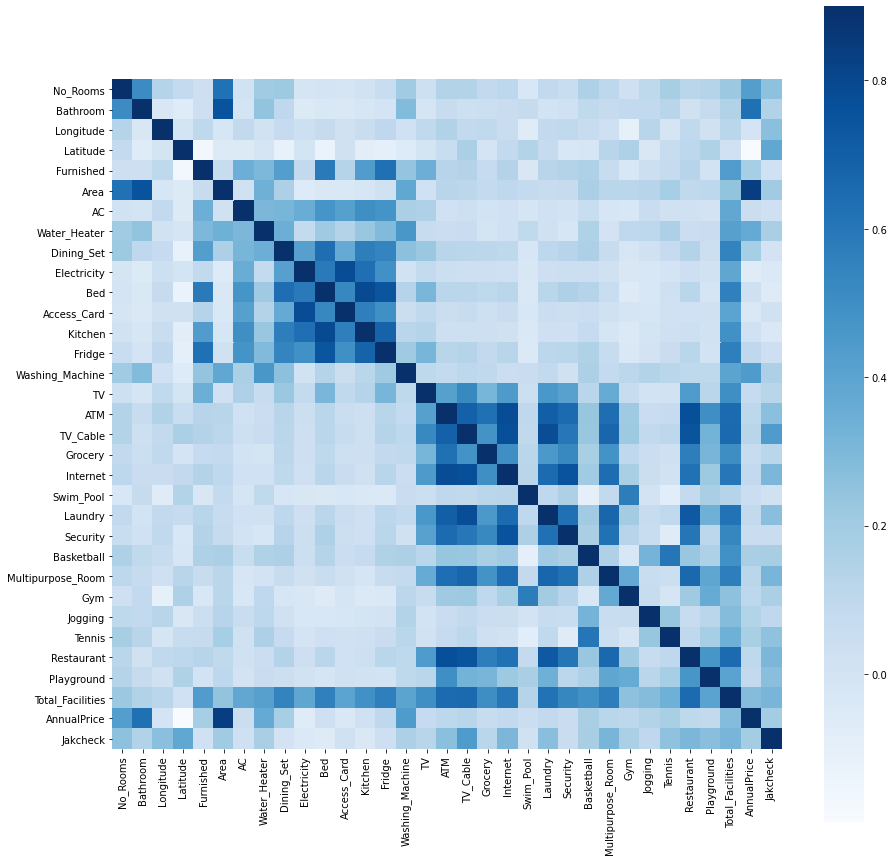

In [13]:
corr = df_clean.corr()
plt.subplots(figsize=(15,15))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

Using seaborn heatmap, we can visualize which of our variables have high correlation with each other. After looking at the heatmap above, there are some insights we can derive. First, our dependent variable, 'AnnualPrice', has a high correlation with the columns 'No_Rooms', 'Area' and surprisingly, the existenec of 'Water_Heater' and 'Washing_Machine'. 

Second, there are four 'groups' of facility variables which are highly correlated to each other. These groups are:
- The first group: 'AC', 'Water_Heater', 'Dining_Set', 'Bed', 'Kitchen', 'Fridge', as well as 'Furnished' variable
- The second group: 'TV', 'ATM', 'TV_Cable', 'Grocery', 'Internet', 'Laundry', 'Security', 'Multipurpose_Room', 'Restaurant' and 'Playground'
- The third group: 'Swim_Pool', 'Gym', 
- The fourth group comprises of: 'Tennis', 'Jogging', 'Basketball'

For example, an apartment unit that has 'Water_Heater' most likely also has 'Dining_Set', 'Electricity', 'Bed', and the facilities in the first group. And another apartment unit which has 'Swim_Pool' most likely also has 'Gym'. Surprisingly, the facility 'Washing_Machine' stands on its own ground for the most part - and only correlates highly to 'Water_Heater' and 'AnnualPrice'. 

A strange thing to note is that 'No_Rooms' have high correlation with 'Area', but don't their p-values are equal to 0 in the four-variable regression? This might seem weird, but we'll get to the bottom of this in a few more steps.

What should we do now? We can create four groups of facilities based on their correlation map above. Then, sum the '0s' and '1s' of the feature in the same group. Use these four sums as numerical variables, and discard all other singular columns of facilities and 'Total_Facilities'. 


In [14]:
Group1 = df_clean.AC + df_clean.Water_Heater + df_clean.Dining_Set + df_clean.Bed + df_clean.Kitchen + df_clean.Fridge + df_clean.Furnished
Group2 = df_clean.TV + df_clean.ATM + df_clean.TV_Cable + df_clean.Grocery + df_clean.Internet + df_clean.Laundry + df_clean.Security + df_clean.Multipurpose_Room + df_clean.Restaurant + df_clean.Playground
Group3 = df_clean.Swim_Pool + df_clean.Gym
Group4 = df_clean.Tennis + df_clean.Jogging + df_clean.Basketball

df_clean['Group1'] = Group1
df_clean['Group2'] = Group2
df_clean['Group3'] = Group3
df_clean['Group4'] = Group4

We're going to do another linear regression but we replace the grouped units with Group1, Group2, Group3, and Group4. 

In [15]:
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm

result_grouped = sm.ols(formula="AnnualPrice ~ No_Rooms + Longitude + Latitude + Group1 + Group2 + Group3 + Group4 + Area", data=df_clean).fit()
print(result_grouped.summary())

                            OLS Regression Results                            
Dep. Variable:            AnnualPrice   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     1857.
Date:                Sun, 06 Dec 2020   Prob (F-statistic):               0.00
Time:                        11:40:34   Log-Likelihood:                -98272.
No. Observations:                5147   AIC:                         1.966e+05
Df Residuals:                    5138   BIC:                         1.966e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.298e+09    1.1e+09     -3.897      0.0

On the bright side, all features' p-values are below 0.05, which means that all of our features are significant. However, our accuracy didn't improve. So we now have 3 models:
- A model with 76% R squared score with lots of features having p-value above 0.05
- A model with 74.7% R squared score with one feature & the intercept having p-value above 0.05 
- A model with 74% R squared score with no features having p-value above 0.05

If we're satisfied with our model, then we'll call it a day. 
However, let's try a few different algorithms and come up with a better model.

### KNN

First, we'll take a look at K Nearest Neighbor Regression. Since this is a distance-based algorithms, our numerical data has to be scaled beforehand.

In [16]:
from sklearn.preprocessing import StandardScaler 
ss = StandardScaler() 

df_numerical = df_clean[['No_Rooms', 'Bathroom', 'Longitude', 'Latitude', 'Area', 'Total_Facilities']] 
df_numerical_scaled = ss.fit_transform(df_numerical)

In [17]:
# Creating a Scaled dataset for KNN Model

X_scaled = df_clean[['Furnished', 'AC', 'Water_Heater', 
                    'Dining_Set', 'Bed', 'Kitchen', 'Fridge', 
                    'Washing_Machine', 'TV', 'ATM', 'TV_Cable', 'Grocery', 'Internet', 'Swim_Pool', 
                    'Laundry', 'Security', 'Basketball', 'Multipurpose_Room', 'Gym', 
                    'Jogging', 'Tennis','Restaurant', 'Playground', 'Jakcheck']]

X_scaled['No_Rooms'] = np.transpose(df_numerical_scaled)[0]
X_scaled['Bathroom'] = np.transpose(df_numerical_scaled)[1]
X_scaled['Longitude'] = np.transpose(df_numerical_scaled)[2]
X_scaled['Latitude'] = np.transpose(df_numerical_scaled)[3]
X_scaled['Area'] = np.transpose(df_numerical_scaled)[4]
X_scaled['Total_Facilities'] = np.transpose(df_numerical_scaled)[5]

y = df_clean[['AnnualPrice']]

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size = 0.2, random_state = 23)

Now, let's test the K Neighbors Regressor on two datasets: first, the non-scaled one (the one that we use for Linear Regression) and second, the scaled one.

Prediction on testing set (non scaled):


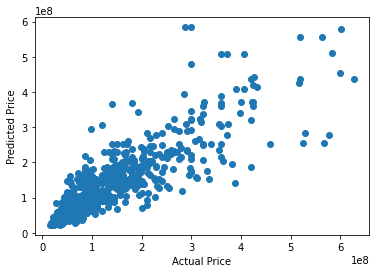

MAE: 25733836.50485437
MSE: 2207006831193320.5
RMSE: 46978791.29131911
R2 Score: 0.7737670658080551
Adjusted R2 Score: 0.7721060310489365


In [18]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
print('Prediction on testing set (non scaled):')
evaluate(knn, X_test, y_test)

Prediction on testing set (scaled):


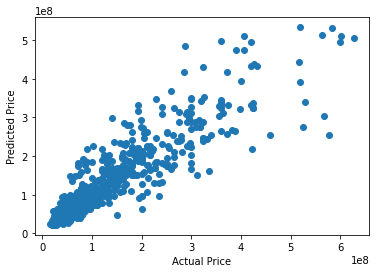

MAE: 21675125.436893202
MSE: 1564773297917514.5
RMSE: 39557215.49752352
R2 Score: 0.8396002905248474
Adjusted R2 Score: 0.838422612775397


In [19]:
knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train_scaled)
print('Prediction on testing set (scaled):')
evaluate(knn, X_test_scaled, y_test_scaled)

We can see that we have a better score when our dataset is scaled. This is already an improvement from our Linear Regression model, but we'll take a look at a few other models before deciding on our final choice.

### Random Forest

Using non-scaled data:
Prediction on testing set:


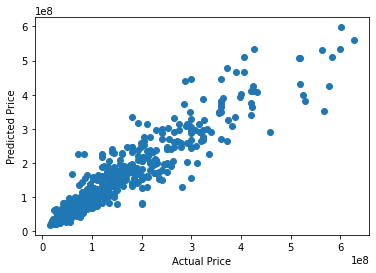

MAE: 17052812.159622997
MSE: 935762803247781.0
RMSE: 30590240.32674116
R2 Score: 0.9040780655074097
Adjusted R2 Score: 0.9033737928606211


In [20]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
print('Using non-scaled data:')
print('Prediction on testing set:')
evaluate(rfr, X_test, y_test)

Using scaled data:
Prediction on testing set (scaled):


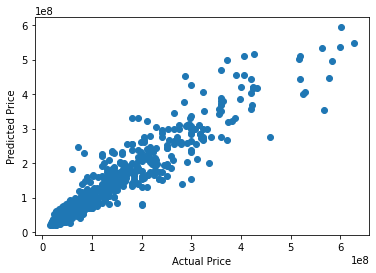

MAE: 17166348.983862035
MSE: 952464638928080.8
RMSE: 30862025.839663874
R2 Score: 0.9023660158485951
Adjusted R2 Score: 0.9016491730868373


In [21]:
print('Using scaled data:')
rfr.fit(X_train_scaled, y_train_scaled)
print('Prediction on testing set (scaled):')
evaluate(rfr, X_test_scaled, y_test_scaled)

The Random Forest Regressor model performs even better than our KNN model. Furthermore, we can notice that it isn't affected by scaling our features. 

### Hyperparameter Tuning of Random Forest Regressor

In [22]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'n_estimators': [10, 20, 40, 60, 80, 100, 120, 150, 180, 200],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
               'min_samples_split': [2, 5, 10, 15, 20],
               'min_samples_leaf': [2, 5, 10, 15, 20],
               'bootstrap': [True, False]}

rfr = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, 
                               n_iter = 500, cv = 5, verbose=1, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  3.5min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 5, 10, 15, 20],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [10, 20, 40, 60, 80,
                                                         100, 120, 150, 180,
                                                         200]},
                   random_state=42, verbose=1)

In [23]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': True}

Prediction on testing set:


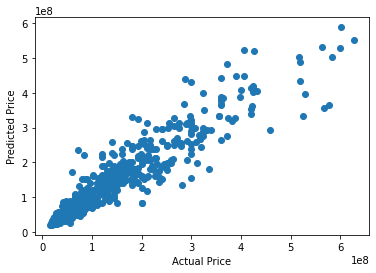

MAE: 17403832.804205526
MSE: 990485752404311.6
RMSE: 31471983.610892907
R2 Score: 0.8984685978880346
Adjusted R2 Score: 0.8977231397227485


In [24]:
rfr_tuned = RandomForestRegressor()
rfr_tuned = RandomForestRegressor(n_estimators = 150, min_samples_split = 2,
                                 min_samples_leaf = 2, max_features = 'auto', 
                                 max_depth = 70, bootstrap = True)
rfr_tuned.fit(X_train, y_train)
print('Prediction on testing set:')
evaluate(rfr_tuned, X_test, y_test)

Hyperparameter tuning doesn't seem to make our model better. We'll continue by looking at the next model, XGBoost.

### XGBoost

XGBoost is a gradient boosted decision trees algorithm which has dominated Kaggle in recent years. Unlike Linear Regression, it does not have to be scaled, and it can handle multicolinearity better since by its nature, decision trees are immune to multicolinearity. However, it will not yield an outcome which can be interpreted as clear as Linear Regression. It doesn't have any explicit coefficient which can further be tested with t-test and calculate it's p-value.

Let's evaluate the XGBoost Regressor's baseline model first against our two datasets - the scaled and the nonscaled one. 

Prediction on testing set (nonscaled):


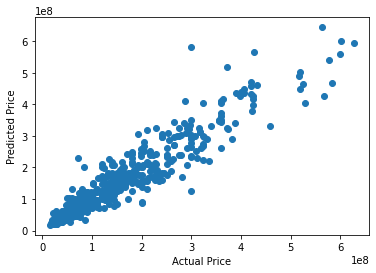

MAE: 16421811.532038836
MSE: 841272188236080.2
RMSE: 29004692.520971157
R2 Score: 0.9137639843661837
Adjusted R2 Score: 0.9131308271295183


In [25]:
import xgboost
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
print('Prediction on testing set (nonscaled):')
evaluate(xgb, X_test, y_test)

Prediction on testing set (scaled):


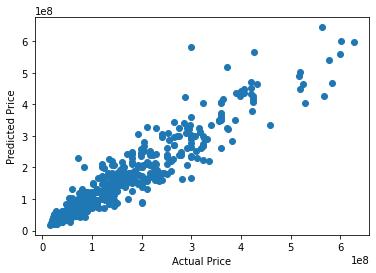

MAE: 16356849.031067962
MSE: 832678181634129.5
RMSE: 28856163.667995255
R2 Score: 0.914644927416538
Adjusted R2 Score: 0.9140182381905214


In [26]:
xgb.fit(X_train_scaled, y_train_scaled)
print('Prediction on testing set (scaled):')
evaluate(xgb, X_test_scaled, y_test_scaled)

As we can see, XGBoost performs better (albeit slightly) than Random Forest. We'll proceed to check if it underfits or overfits, and then do hyperparameter tuning on it

### Testing XGBoost Model for Overfitting and Underfitting

After choosing our model, we have to make sure that it doesn't overfit nor underfit. 

Before we go deeper, let's talk about bias-variance tradeoff.

Ideally, a machine learning model should be able to identify the complexity of our dataset, yet it is also 'generalized' enough to handle unseen data (data points which are not from the training set). However, we cannot get both at the same time, realistically. A model that captures the relation of each parameters in a complex manner, usually are bad at 'generalizing' unseen data. On the other side, a model that is pretty robust to unseen data does not 'learn' the data deep enough. 

We all recognize these two kids at school - or perhaps we're one of them: 
- A student who is good at memorizing study materials to a point where he/she can remember all the punctuations in a text.
- A student who rarely studies, but understands the lesson in a 'big picture'.

Usually, the first student is great when the test questions are taken from the study materials directly, while the second student might not perform as well. However, when the test questions are not taken from the study materials, the first student usually does not perform well, while the second student can give a good generalized answer. 

The same applies to our supervised learning models. Now the question is, which 'student' do we want our models to be? The first student, or the second student? If we know that our training data itself is pretty robust, and the 'unseen' data is pretty homogeneous, leading our model to be the first student might be better. However, if we have a limited training data, and we are unsure of what the 'unseen' data looks like out there, we might place a better bet by leading our model to be more like the second student.

The first student has lower bias but higher variance, while the second student has higher bias but lower variance.

Bias error is an error which is caused by a 'wrong' assumption in a learning algorithm (meaning the learning algorithm isn't optimized well). Higher bias happens a model miss the relationship between features and target output. When a model has high bias, we can call that it underfits.

Variance error is an error which is caused by small fluctuations in the training data. If a model is too tuned to learn a training set, it will model a relationship which is too complex among the features and the target output, and unseen data point will be wrongly predicted. When this happens, we can call that it overfits.

And we say that this is a tradeoff because one cannot get the best of both worlds. A higher accuracy might give the illussion that our model perfoms well, but it might show tendencies of overfitting. Reducing accuracy might hinder us from overfitting, but push it too far and our model will underfit. 

First, let's check whether our baseline model underfits or overfits.

Prediction on testing set:


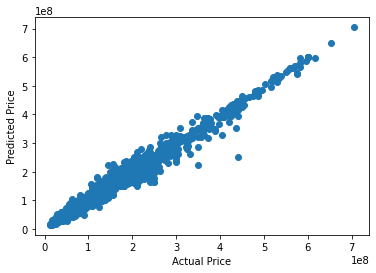

MAE: 7668730.983726014
MSE: 154949322680724.06
RMSE: 12447864.181486078
R2 Score: 0.9817325201829521
Adjusted R2 Score: 0.981598397717335


Prediction on training set:


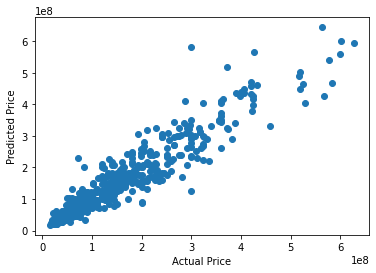

MAE: 16421811.532038836
MSE: 841272188236080.2
RMSE: 29004692.520971157
R2 Score: 0.9137639843661837
Adjusted R2 Score: 0.9131308271295183


In [27]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
print('Prediction on testing set:')
evaluate(xgb, X_train, y_train)
print('\n')
print('Prediction on training set:')
evaluate(xgb, X_test, y_test)

When our baseline model is used to predict the training set, it achieved an RMSE of below 12.5 million, however, when it is used to predict the testing set, its rmse is about 29 million. This shows that there might be an overfitting issue. 

Now we are given two options. We can stop at this stage, and accept that our model probably behaves like the 'first student' from the analogy above, or we can try to make it less overfit. Both are actually acceptable, as the testing R-squared score has already reached above 90% (meaning that our model are also capable in predicting 'unseen' data points).

We will try to do some hyperparameter tuning to solve this overfitting issue, and see where it leads us to. First, let's take a look at the default parameters of our baseline model.

In [28]:
xgb.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)>

A good way to know what these parameters mean is by checking the documentation of our model - in this case, XGBoost. 
https://xgboost.readthedocs.io/en/latest/parameter.html

If we read the documentation, it gives us a sense of what parameters to tune in order to reduce overfitting. However, we have to remember the tradeoff - reducing overfitting might cause our model's overall accuracy to decrease too. Our objective is to find a sweet spot - where our model does not overfit too much, while still having a good accuracy.

These are the parameters we're going to tune:
- ```max_depth```. According to the documentation, this adjusts how deep our tree is. Deeper tree will result in more complex model which is both more computationally intensive and prune to overfitting.
- ```min_child_weight```. A higher value of this parameter will make our model 'more difficult' to add partitions in the decision trees. Thus, it will reduce overfitting. However, make it too large and the model will underfit.
- ```subsample```. The ratio of training instances. If say our subsample value is 0.5, then XGBoost would randomly sample half of the training data prior to growing trees. This will reduce overfitting.
- ```lambda``` and ```alpha```. Both are the regularization parameters (L2 and L1 respectively), and increasing both values will help reduce overfitting.

In [29]:
grid_params = {
    
    'max_depth' : [2,3,4,5,6,7,8],
    'min_child_weight' : [5,7,10],
    'subsample': [0.3, 0.4, 0.5],
    'lambda' : [2,4,6,8,10],
    'alpha' : [3,5,7,9]
}

xgb = XGBRegressor()
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = grid_params, 
                                     n_iter = 200, cv = 5, verbose = 1, random_state = 42, n_jobs = -1)
xgb_random.fit(X_train, y_train)
print(xgb_random.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.1min finished


{'subsample': 0.5, 'min_child_weight': 5, 'max_depth': 6, 'lambda': 10, 'alpha': 9}


Prediction on Training Set:


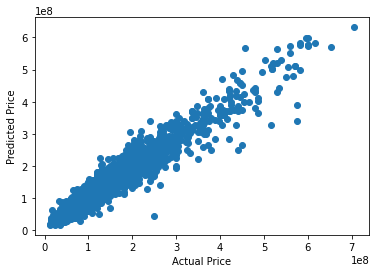

MAE: 13211950.699052708
MSE: 456444718903064.0
RMSE: 21364566.901836883
R2 Score: 0.9461882469319302
Adjusted R2 Score: 0.9457931532970691


Prediction on Testing Set:


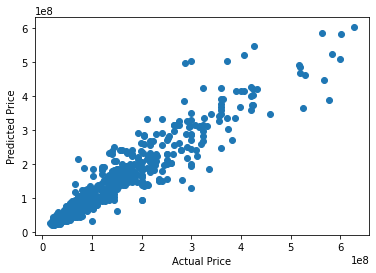

MAE: 17474662.53592233
MSE: 925037067416551.6
RMSE: 30414422.029960584
R2 Score: 0.9051775250352058
Adjusted R2 Score: 0.9044813247784892


In [30]:
xgb_tuned = XGBRegressor(n_estimators=75, subsample=0.5, min_child_weight=5, max_depth=5, reg_lambda=10, alpha=9)
xgb_tuned.fit(X_train, y_train)
print('Prediction on Training Set:')
evaluate(xgb_tuned, X_train, y_train)
print('\n')
print('Prediction on Testing Set:')
evaluate(xgb_tuned, X_test, y_test)

After tuning, we see a slight decrease in the testing set's performance metric. However, the training and the testing set's metrics are not too far off such as with the baseline model. We are sure that now, our tuned model has less tendency to overfit. 

After tuning an XGB Regressor, we'll compare its performance with its close relative, the Light GBM Regressor.

### Light GBM

LightGBM is originally developed by Microsoft. We can access the official documentation here: https://lightgbm.readthedocs.io/en/latest/.

Quoting its preface words:

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:
- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel and GPU learning.
- Capable of handling large-scale data.

Let's try how it fares against other previous algorithms when we fit in our data.

Prediction on testing set (nonscaled):


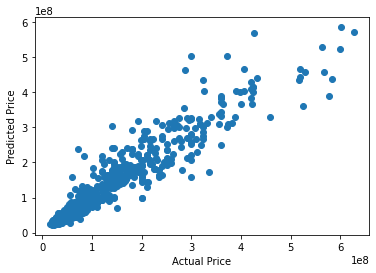

MAE: 17058978.205421235
MSE: 925119338028843.9
RMSE: 30415774.493325725
R2 Score: 0.9051690917482066
Adjusted R2 Score: 0.9044728295730833


In [31]:
import lightgbm
from lightgbm import LGBMRegressor

lgb = LGBMRegressor()
lgb.fit(X_train, y_train)
print('Prediction on testing set (nonscaled):')
evaluate(lgb, X_test, y_test)

Prediction on training set (scaled):


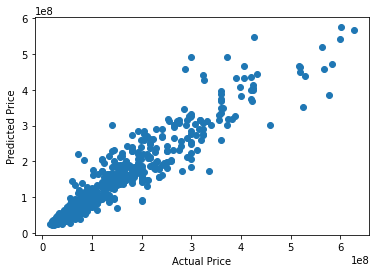

MAE: 17126197.553154346
MSE: 885615675004517.1
RMSE: 29759295.60665906
R2 Score: 0.9092184809349592
Adjusted R2 Score: 0.9085519499579765


In [32]:
lgb.fit(X_train_scaled, y_train_scaled)
print('Prediction on training set (scaled):')
evaluate(lgb, X_test_scaled, y_test_scaled)

Just like Random Forest Regressor and XGBoost, these decision tree-based models are not affected by scaling the data. Now, let's check if the baseline model tends to overfit, just like what we did with the XGB Regressor.

Prediction on training set:


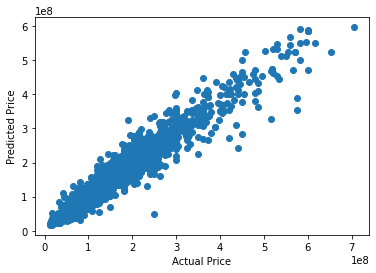

MAE: 12313257.21905091
MSE: 424323901386370.5
RMSE: 20599123.80142346
R2 Score: 0.9499750746220538
Adjusted R2 Score: 0.949607784421041


Prediction on testing set:


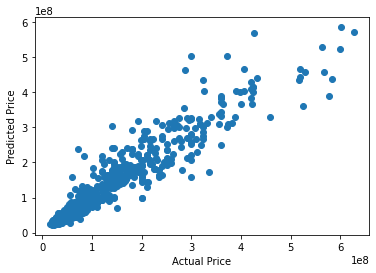

MAE: 17058978.205421235
MSE: 925119338028843.9
RMSE: 30415774.493325725
R2 Score: 0.9051690917482066
Adjusted R2 Score: 0.9044728295730833


In [33]:
lgb = LGBMRegressor()
lgb.fit(X_train, y_train)
print('Prediction on training set:')
evaluate(lgb, X_train, y_train)
print('\n')
print('Prediction on testing set:')
evaluate(lgb, X_test, y_test)

This sure is quite a surprise, as the baseline LGBM model does not seem to overfit as much as the baseline XGB model. Other than that, it gives quite a similar performance to our tuned XGBoost model.

At this point, let's recap what we have done:
- We have scraped and cleaned our data
- We have tried to model a Linear Regression, but it seems that our data is not linear
- We have tried a few ML algorithms: KNN, Random Forest, XGB, and Light GBM
- We have two models that has an R2-score of around 90% that does not overfit (tuned XGBoost and baseline Light GBM)

Our two best models are elligible to be chosen as our final model. If this project is rushed, and on a tight deadline, then we can just pick one, and save it. 

However, as this project is also a learning journey for myself, I wanted to try something different. I wanted to try if we can create a new 'regressor' whose output prediction is the average of XGB and Light GBM predictions. And I wanted to see if taking the average of both models can yield a better result. 

### Simple Stacking of Regressors

The idea of simple stacking regression models is to create a new prediction which is the linear combination of predictions from different models. In this project, let's try to create two new predictors:
- first 'model': the average of tuned Random Forest Regressor, tuned XGB Regressor, and baseline Light GBM Regressor
- second 'model': the average of tuned XGB Regressor and baseline Light GBM Regressor

First, we'll create a helper function to evaluate our model, and create a new class which takes in the inputed models and create an average prediction.

In [34]:
def evaluate_pred(y_test, avg_prediction):
    test_val = y_test['AnnualPrice'].to_numpy().reshape(len(y_test.AnnualPrice), 1)
    plt.scatter(test_val, avg_prediction)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.show()
    from sklearn import metrics
    print('MAE:', metrics.mean_absolute_error(test_val, avg_prediction))
    print('MSE:', metrics.mean_squared_error(test_val, avg_prediction))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(test_val, avg_prediction)))
    print('R2 Score:', metrics.r2_score(test_val, avg_prediction))

In [35]:
from sklearn.base import clone
class Average_Regressor():

    def __init__(self, models):
        self.models = [x for x in models]
        self.models_ = [clone(x) for x in self.models]
    
    def fit(self, X, y):        
        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        prediction = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(prediction, axis=1)

Let's try our first 'model'.

Prediction metrics on training data:


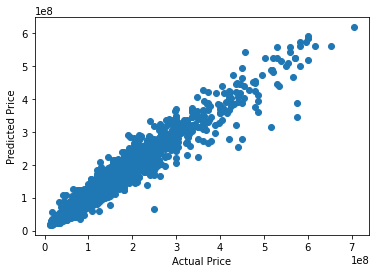

MAE: 11334946.72046761
MSE: 377534345423584.1
RMSE: 19430243.061361432
R2 Score: 0.9554912476159817


Prediction metrics on testing data:


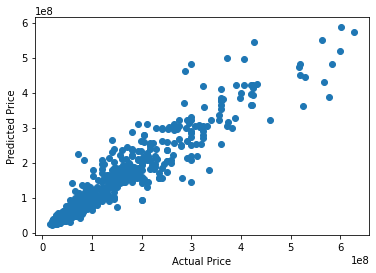

MAE: 16707303.821890004
MSE: 882391842534744.6
RMSE: 29705081.089516398
R2 Score: 0.9095489452854413


In [36]:
avg_reg_1 = Average_Regressor(models = [rfr_tuned, xgb_tuned, LGBMRegressor()])
avg_reg_1.fit(X_train, y_train)
print('Prediction metrics on training data:')
evaluate_pred(y_train, avg_reg_1.predict(X_train))
print('\n')
print('Prediction metrics on testing data:')
evaluate_pred(y_test, avg_reg_1.predict(X_test))

Prediction metrics on training data:


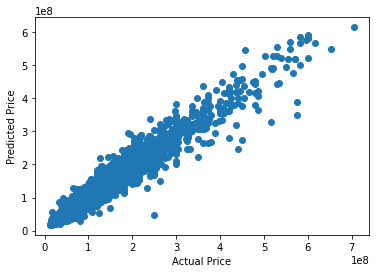

MAE: 12435293.507116834
MSE: 420613430591354.06
RMSE: 20508862.245169867
R2 Score: 0.9504125140970192


Prediction metrics on testing data:


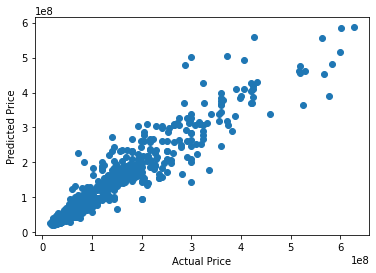

MAE: 16879007.482693672
MSE: 890963672187208.4
RMSE: 29849014.593235876
R2 Score: 0.9086702755204629


In [37]:
avg_reg_2 = Average_Regressor(models = [xgb_tuned, LGBMRegressor()])
avg_reg_2.fit(X_train, y_train)
print('Prediction metrics on training data:')
evaluate_pred(y_train, avg_reg_2.predict(X_train))
print('\n')
print('Prediction metrics on testing data:')
evaluate_pred(y_test, avg_reg_2.predict(X_test))

On a glance, the new models has worse/same than both our XGB and Light GBM Regressor. Well, that's it folks. Game's over. Or is it? 

We've gotten this far, and it feels that we need to have an all-out battle royale between all our top models. And by battle royale I mean comparing all of them 1000 times on different train and test splits. 

We are going to split the data into train and test splits 500 times using randomized ```random_state``` and evaluate our models on each iterations. In the end, we'll have 500 RMSE and R2-score metrics for each models, and we'll compare them to see which model truly performs the best.

Again, another disclaimer here: this step is computationally intensive and time-consuming. In a tighter deadline, we'd just go with one of the top models and call it a day. However, for curiosity's sake, let's try it.

### Comparing our 'Average Model' against Each Regression Models

Disclaimer: this is a computationally intensive process which might not be the best way to evaluate if our average model performs better than our three regression models. That can be done much quicker with a cross validation. However, I want to visualize the results in a more detailed manner, and I want to do it over 1000 iterations. Here's how we're going to do it.

1. Split the data into train-test split using randomized ```random_state```
2. Initialize our 5 models (average_1, average_2, random forest, xgboost, and light gbm)
3. Fit each model on the training set
4. Evaluate each model's prediction on the testing set (Metric: RMSE and R2-score)
5. Repeat step 1-4 500 times, and store the result in a dataframe

In [41]:
from random import randint
from sklearn import metrics

RFR_RMSE = list()
RFR_R2 = list()

XGB_RMSE = list()
XGB_R2 = list()

LGB_RMSE = list()
LGB_R2 = list()

AVG1_RMSE = list()
AVG1_R2 = list()

AVG2_RMSE = list()
AVG2_R2 = list()

for i in range(500):
    print('Iteration', i, ' passed.')
    random_integer = randint(0,100000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_integer)
    test_val = y_test['AnnualPrice'].to_numpy().reshape(len(y_test.AnnualPrice), 1)
      
    rfr_iter = RandomForestRegressor(n_estimators = 150, min_samples_split = 2,
                                 min_samples_leaf = 2, max_features = 'auto', 
                                 max_depth = 70, bootstrap = True)
    rfr_iter.fit(X_train, y_train)
    rfr_predict = rfr_iter.predict(X_test)
    rfr_rmse = np.sqrt(metrics.mean_squared_error(test_val, rfr_predict))
    RFR_RMSE.append(rfr_rmse)
    rfr_adjr2 = 1-(1-metrics.r2_score(test_val, rfr_predict))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
    RFR_R2.append(rfr_adjr2)    
    
    xgb_iter = XGBRegressor(n_estimators=75, subsample=0.5, min_child_weight=5, max_depth=5, reg_lambda=10, alpha=9)
    xgb_iter.fit(X_train, y_train)
    xgb_predict = xgb_iter.predict(X_test)
    xgb_rmse = np.sqrt(metrics.mean_squared_error(test_val, xgb_predict))
    XGB_RMSE.append(xgb_rmse)
    xgb_adjr2 = 1-(1-metrics.r2_score(test_val, xgb_predict))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
    XGB_R2.append(xgb_adjr2)
    
    lgb_iter = LGBMRegressor()
    lgb_iter.fit(X_train, y_train)
    lgb_predict = lgb_iter.predict(X_test)
    lgb_rmse = np.sqrt(metrics.mean_squared_error(test_val, lgb_predict))
    LGB_RMSE.append(lgb_rmse)
    lgb_adjr2 = 1-(1-metrics.r2_score(test_val, lgb_predict))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
    LGB_R2.append(lgb_adjr2)
    
    avg_reg = Average_Regressor(models=[rfr_iter, xgb_iter, lgb_iter])
    avg_reg.fit(X_train, y_train)
    avg_predict = avg_reg.predict(X_test)
    avg_rmse = np.sqrt(metrics.mean_squared_error(test_val, avg_predict))
    AVG1_RMSE.append(avg_rmse)
    avg_adjr2 = 1-(1-metrics.r2_score(test_val, avg_predict))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
    AVG1_R2.append(avg_adjr2)
    
    avg2_reg = Average_Regressor(models=[lgb_iter, xgb_iter])
    avg2_reg.fit(X_train, y_train)
    avg2_predict = avg2_reg.predict(X_test)
    avg2_rmse = np.sqrt(metrics.mean_squared_error(test_val, avg2_predict))
    AVG2_RMSE.append(avg2_rmse)
    avg2_adjr2 = 1-(1-metrics.r2_score(test_val, avg2_predict))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
    AVG2_R2.append(avg2_adjr2)
    
df = pd.DataFrame(zip(RFR_RMSE, RFR_R2, XGB_RMSE, XGB_R2, LGB_RMSE, LGB_R2, AVG1_RMSE, AVG1_R2, AVG2_RMSE, AVG2_R2))
df = df.rename({0:'RFR_RMSE', 1:'RFR_R2', 2:'XGB_RMSE', 3:'XGB_R2', 4:'LGB_RMSE', 5:'LGB_R2',
               6:'AVG1_RMSE', 7:'AVG1_R2', 8:'AVG2_RMSE', 9:'AVG2_R2'}, axis = 'columns')
    

Iteration 0  passed.
Iteration 1  passed.
Iteration 2  passed.
Iteration 3  passed.
Iteration 4  passed.
Iteration 5  passed.
Iteration 6  passed.
Iteration 7  passed.
Iteration 8  passed.
Iteration 9  passed.
Iteration 10  passed.
Iteration 11  passed.
Iteration 12  passed.
Iteration 13  passed.
Iteration 14  passed.
Iteration 15  passed.
Iteration 16  passed.
Iteration 17  passed.
Iteration 18  passed.
Iteration 19  passed.
Iteration 20  passed.
Iteration 21  passed.
Iteration 22  passed.
Iteration 23  passed.
Iteration 24  passed.
Iteration 25  passed.
Iteration 26  passed.
Iteration 27  passed.
Iteration 28  passed.
Iteration 29  passed.
Iteration 30  passed.
Iteration 31  passed.
Iteration 32  passed.
Iteration 33  passed.
Iteration 34  passed.
Iteration 35  passed.
Iteration 36  passed.
Iteration 37  passed.
Iteration 38  passed.
Iteration 39  passed.
Iteration 40  passed.
Iteration 41  passed.
Iteration 42  passed.
Iteration 43  passed.
Iteration 44  passed.
Iteration 45  passed

Iteration 361  passed.
Iteration 362  passed.
Iteration 363  passed.
Iteration 364  passed.
Iteration 365  passed.
Iteration 366  passed.
Iteration 367  passed.
Iteration 368  passed.
Iteration 369  passed.
Iteration 370  passed.
Iteration 371  passed.
Iteration 372  passed.
Iteration 373  passed.
Iteration 374  passed.
Iteration 375  passed.
Iteration 376  passed.
Iteration 377  passed.
Iteration 378  passed.
Iteration 379  passed.
Iteration 380  passed.
Iteration 381  passed.
Iteration 382  passed.
Iteration 383  passed.
Iteration 384  passed.
Iteration 385  passed.
Iteration 386  passed.
Iteration 387  passed.
Iteration 388  passed.
Iteration 389  passed.
Iteration 390  passed.
Iteration 391  passed.
Iteration 392  passed.
Iteration 393  passed.
Iteration 394  passed.
Iteration 395  passed.
Iteration 396  passed.
Iteration 397  passed.
Iteration 398  passed.
Iteration 399  passed.
Iteration 400  passed.
Iteration 401  passed.
Iteration 402  passed.
Iteration 403  passed.
Iteration 4

In [42]:
df.describe()

,RFR_RMSE,RFR_R2,XGB_RMSE,XGB_R2,LGB_RMSE,LGB_R2,AVG1_RMSE,AVG1_R2,AVG2_RMSE,AVG2_R2
count,5.000000e+02,500.000000,5.000000e+02,500.000000,5.000000e+02,500.000000,5.000000e+02,500.000000,5.000000e+02,500.000000
mean,3.095383e+07,0.888679,3.129364e+07,0.886272,3.004878e+07,0.895118,2.992080e+07,0.896011,3.009178e+07,0.894829
std,2.078432e+06,0.013462,1.993779e+06,0.012923,1.981156e+06,0.012368,1.977281e+06,0.012273,1.958180e+06,0.012215
min,2.432089e+07,0.844734,2.490106e+07,0.841955,2.415364e+07,0.855301,2.361400e+07,0.858179,2.398040e+07,0.856498
25%,2.956109e+07,0.880771,2.993390e+07,0.879897,2.855239e+07,0.888500,2.850642e+07,0.889263,2.876342e+07,0.888426
50%,3.094033e+07,0.889727,3.134558e+07,0.887480,3.001085e+07,0.896389,2.988421e+07,0.897027,3.007948e+07,0.896159
75%,3.225563e+07,0.897584,3.253210e+07,0.894261,3.133147e+07,0.903195,3.119241e+07,0.903863,3.136686e+07,0.902511
max,3.963358e+07,0.927278,3.745463e+07,0.921333,3.781142e+07,0.923134,3.745149e+07,0.926490,3.711164e+07,0.924894


In [43]:
df.to_csv('Model Comparison.csv')

There are a few takeaways from this result:
- The first average regressor (that takes in the result of Random Forest, XGB, and Light GBM Regressor and averages them out) seems to be the best performing model, followed by Light GBM Regressor, the second average regressor, then the XGB Regressor, and finally, the Random Forest Regressor.
- The gap between the first average regressor and the Light GBM Regressor is miniscule. The difference in R2-score is only by 0.1%, and around 100000 on the RMSE. 
- While this new model has improved performance, it seems that the improvement gain is not that much that it immediately becomes the go-to method to create a better regression result.

Unless we're competing in a Kaggle competition in which a 0.1% change in accuracy makes a difference, or we have a lot of computational power at our expenses, we should be content with our baseline Light GBM model. And thus, using these results, we will decide that the baseline Light GBM model is our model of choice in this project.

### Hyperparameter Tuning on Light GBM Regressor

Now why did I not do hyperparameter tuning on Light GBM Regressor earlier? Well, I did, (in a separate notebook), and the tuned Light GBM Regressor only gets better in its prediction on training data. Prediction metrics on testing data does not show any meaningful improvement, and this only causes the tuned model to have a worse overfitting issue than the baseline model.

In [127]:
grid_params = {
    'max_depth' : [3,5,7,9,11],
    'num_leaves' : [10,20,50,80,100,120,150,200],
    'min_data_in_leaf' : [10, 20, 50, 100, 150, 200, 250],
    'feature_fraction' : [0.4, 0.5, 0.6, 0.7]
}

lgb = LGBMRegressor()
lgb_random = RandomizedSearchCV(estimator = lgb, param_distributions = grid_params, 
                                     n_iter = 250, cv = 5, verbose = 1, random_state = 42, n_jobs = -1)
lgb_random.fit(X_train, y_train)
print(lgb_random.best_params_)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:   14.8s finished


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
{'num_leaves': 200, 'min_data_in_leaf': 10, 'max_depth': 11, 'feature_fraction': 0.4}


Prediction on training data:


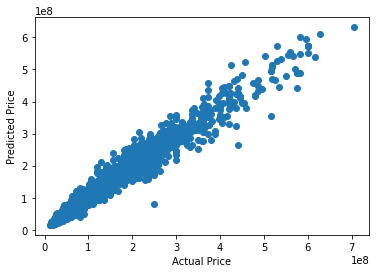

MAE: 9865858.23001457
MSE: 280903353506318.44
RMSE: 16760171.643104328
R2 Score: 0.9677805808670656
Adjusted R2 Score: 0.9675440212552232
Prediction on testing data:


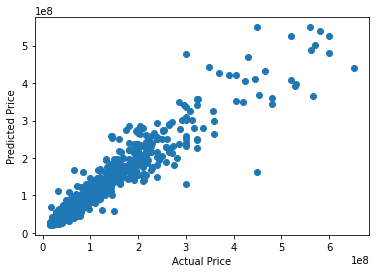

MAE: 16230802.828968147
MSE: 860396888945625.6
RMSE: 29332522.717039283
R2 Score: 0.9025631361101454
Adjusted R2 Score: 0.9018477406337148


In [128]:
lgb_tuned = LGBMRegressor(num_leaves = 200, min_data_in_leaf = 10, max_depth = 11, feature_fraction = 0.4)
lgb_tuned.fit(X_train, y_train)
print('Prediction on training data:')
evaluate(lgb_tuned, X_train, y_train)
print('Prediction on testing data:')
evaluate(lgb_tuned, X_test, y_test)

This is an interesting insight. Baseline XGBoost Regressor model tends to overfit, and we have to tune it so that its overfitting tendencies can be lessened. However, the baseline Light GBM Regressor model tends to be more conservative - and tuning it makes it overfits. 

I don't know if this tendency happens to other datasets and cases too, but it certainly seems to be that way in our project's case. And thus, we have decided on a model to be our final choice: the baseline Light GBM Regressor.

### Creating Prediction Interval

Our final step is trying to create a prediction interval for our prediction. When we say we predict that the annual rent price of apartment X is IDR Y, there is some uncertainty to it. Based on feedbacks from my first iteration of this web app project, I was challenged to create a prediction interval, so users of the web app can know the 'price range' instead of just having a single price. 

Suppose that we input a certain type of apartment, and the prediction comes in a 99% prediction interval. How do we interpret this? It means the model is willing to bet that the actual annual rent price of that apartment falls within the prediction interval, with 1% chance of being wrong. The probability that the actual rent price is outside the interval is 1%, according to our model.

However, in real life, this does not mean that out of 100 predictions, our model is always correct in 99 of them. It is possible that, say, among 100 apartments which are predicted, there are more than 1 apartment whose annual rent price is outside the prediction interval. 

This is why we need to test our prediction intervals on the test data. 

We're going to evaluate a 99% prediction interval and 95% prediction interval.

In [89]:
y_preds = np.zeros((X_test.shape[0], 4))
# insert quantiles that we want to check
quantiles = [.01, .05, .95, .99]

# the process is similar to how we do our usual train test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
test_val = y_test['AnnualPrice'].to_numpy().reshape(len(y_test.AnnualPrice), 1)

# however, there will be 4 generated outputs for each input, each one of them corresponds to the quantiles that we specify

for i in range(len(quantiles)):
    lgb = LGBMRegressor(objective = 'quantile', alpha=quantiles[i])
    model = lgb.fit(X_train, y_train)
    y_preds[:, i] = model.predict(X_test)

In [90]:
ActualPrice = list()
I_1 = list()
I_99 = list()
is_in_1_99 = list()
I_5 = list()
I_95 = list()
is_in_5_95 = list()

for i in range(len(test_val)):
    actual_price = test_val[i][0]
    ActualPrice.append(actual_price)
    pred_1_prcnt = y_preds[i][0]
    I_1.append(pred_1_prcnt)
    pred_5_prcnt = y_preds[i][1]
    I_5.append(pred_5_prcnt)
    pred_95_prcnt = y_preds[i][2]
    I_95.append(pred_95_prcnt)
    pred_99_prcnt = y_preds[i][3]
    I_99.append(pred_99_prcnt)
    
    if actual_price < pred_99_prcnt and actual_price > pred_1_prcnt:
        is_in_1_99.append(1)
    else:
        is_in_1_99.append(0)
    
    if actual_price < pred_95_prcnt and actual_price > pred_5_prcnt:
        is_in_5_95.append(1)
    else:
        is_in_5_95.append(0)
        

quantile_pred = pd.DataFrame(zip(ActualPrice, I_1, I_99, is_in_1_99, I_5, I_95, is_in_5_95))
quantile_pred = quantile_pred.rename({0:'Actual Annual Rent Price', 1:'Quantile 0.01', 2:'Quantile 0.99',
                                     3:'Between 1% and 99%', 4:'Quantile 0.05', 5:'Quantile 0.95',
                                     6:'Between 5% and 95%'}, axis = 'columns')

In [93]:
quantile_pred.describe()

,Actual Annual Rent Price,Quantile 0.01,Quantile 0.99,Between 1% and 99%,Quantile 0.05,Quantile 0.95,Between 5% and 95%
count,1.030000e+03,1.030000e+03,1.030000e+03,1030.000000,1.030000e+03,1.030000e+03,1030.000000
mean,9.937600e+07,4.666704e+07,1.644065e+08,0.933010,6.842795e+07,1.395170e+08,0.848544
std,8.832276e+07,1.659497e+07,1.225526e+08,0.250127,4.624754e+07,1.139262e+08,0.358667
min,1.200000e+07,1.378095e+07,3.318397e+07,0.000000,1.337708e+07,3.656072e+07,0.000000
25%,4.228750e+07,3.327743e+07,7.596994e+07,1.000000,3.563150e+07,6.058561e+07,1.000000
50%,6.500000e+07,4.321431e+07,1.025462e+08,1.000000,5.030888e+07,9.027112e+07,1.000000
75%,1.275000e+08,6.177286e+07,2.197438e+08,1.000000,8.836435e+07,1.878036e+08,1.000000
max,5.959000e+08,8.762887e+07,6.949314e+08,1.000000,2.470854e+08,6.547659e+08,1.000000


We see how many apartments in our test set whose actual annual rent price is within the prediction interval given by our regression model. It turns out that 93% of the test set apartments' actual rent price is within the 99% confidence interval given by our regression model. However, only 85% of them is within the 95% confidence interval. This is not necessarily a bad thing, as it is often that the actual price is just one or two million above/below the prediction interval.

A higher prediction interval (in this case, 99%) has a wider range, while a lower prediction interval (95%) has a shorter range. This is the tradeoff that we have to face in dealing with prediction and/or confidence intervals.

### Saving the Models

At last, let's train the model to our whole data and pickle them.

In [22]:
lgb_final = LGBMRegressor()
lgb_final.fit(X, y)

lgb_001 = LGBMRegressor(objective = 'quantile', alpha = 0.01)
lgb_099 = LGBMRegressor(objective = 'quantile', alpha = 0.99)

lgb_001.fit(X,y)
lgb_099.fit(X,y)

lgb_005 = LGBMRegressor(objective = 'quantile', alpha = 0.05)
lgb_095 = LGBMRegressor(objective = 'quantile', alpha = 0.95)

lgb_005.fit(X,y)
lgb_095.fit(X,y)


import joblib 

joblib.dump(lgb_final, 'lgb_final.joblib.dat')
joblib.dump(lgb_001, 'lgb_001.joblib.dat')
joblib.dump(lgb_099, 'lgb_099.joblib.dat')

joblib.dump(lgb_005, 'lgb_005.joblib.dat')
joblib.dump(lgb_095, 'lgb_095.joblib.dat')

['lgb_095.joblib.dat']

### Feature Importance

Last but not least, we want to see the rank of feature importance in our dataset. According to the LGBMRegressor documentation, we can call the regressor's attribute named ```feature_importances_``` to see how many times each feature has been used in the decision tree splitting process. The more times a feature is used to split trees, the more important it is.

In [25]:
feature_imp = pd.DataFrame(zip(X.columns, lgb_final.feature_importances_))
feature_imp = feature_imp.rename({0:'Feature Name', 1:'Importance'}, axis = 'columns')
feature_imp = feature_imp.sort_values(by=['Importance'], ascending = [False]).reset_index(drop = True)
feature_imp.to_csv('Feature Importance.csv')

In [26]:
feature_imp

,Feature Name,Importance
0,Area,869
1,Latitude,712
2,Longitude,680
3,Total_Facilities,184
4,No_Rooms,84
5,Washing_Machine,54
6,Bathroom,46
7,Tennis,40
8,Basketball,40
9,Furnished,39


Another disclaimer inbound. Usually, it is a good idea to discard features which are less important. It could help avoid overfitting, it makes training faster, and it reduces somehwat 'unncessary' complexities. 

Why we don't do that here?
1. We see that Total_Facilities is one of the most important features. Total_Facilities count how many facilities are present in each apartment, and if we discard a few of the least important features, it will definitely affect Total_Facilities. 
2. I want all features which are listed to be inputs of our users in the deployed web app. Even if we know that TV and Swimming Pool are actually the least important features in our dataset, our users wouldn't know that, and would question us why does our input page does not show two of the more common apartment features: swimming pool and TV.

### Concluding Remarks

- The regression model that we choose to model our data is Light GBM Regressor. We have verified in a series of tests that this model shows high accuracy and has less overfitting issues compared to other models. 
- The top 5 most important features are: Area, Latitude, Longitude, Total_Facilities, and No_Rooms. This is confirming what Jakartans think about apartment prices: the more rooms they have, and the larger the area is, the more expensive the price is. Also, we see that the location of apartments, as well as how much features it has, are also important features to predict the annual rent price.
- Surprisingly, not all sports facilities share the same importance. Gym and Swimming Pool are less important than Tennis, Basketball, and Jogging tracks. 
- We used to think that apartments with swimming pools are 'elite' and thus more expensive. However, this doesn't seem to be the case. In fact, most apartments in Jakarta have swimming pools. Swimming pools are no longer exclusive facilities for elite apartments. That's why the presence of swimming pools hardly matter in predicting annual rent price.
- An interesting metric to add, if available, is to measure how wide or how luxurious each sport facilities are. Swimming pools in expensive apartments are often luxurious, and some are placed in higher floors, while swimming pools in less expensive apartments are fairly standard. Gyms in expensive apartments are often coming from well known brands - while gyms in less expensive apartments are nameless gyms with barebone equipments.